<a href="https://colab.research.google.com/github/reitezuz/18NES1-2025-/blob/main/week9/CNN_transfer_learning_flowers_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network – Classifying Images from the Oxford Flowers Dataset

## Transfer Learning and Fine-tuning

Data: [Oxford 102 Category Flower Dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/)

🌸 The Oxford Flowers dataset is a collection of color images of flowers commonly found in the United Kingdom. It contains **8189** images grouped into **102** categories, with class labels and a standard split into training, validation, and test sets. The images vary in scale, pose, and lighting conditions, making the dataset a rich and challenging benchmark for image classification tasks.

The dataset provides an excellent example of multi-class classification using images that are visually similar yet distinct enough to allow for effective learning using CNNs.

The full dataset can be downloaded from:

    https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

We will work with **the whole dataset of 102 classes or with a smaller dataset containing just three classes** depending on the setting of the parameter `all_classes`.

In [ ]:
all_classes = False

# 1. Process the data

## Download the dataset
1. Downloads the flower image archive as 102flowers.tgz, containing all flower images.
2. Extracts the images into a folder called images.
3. Downloads the image labels in the file imagelabels.mat (MATLAB format).
4. Optionally: Downloads the dataset split indices in the file setid.mat, which tells you which images belong to training, validation, and test sets.

In [ ]:
import os
import tarfile
import requests

url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz" # url of the dataset
images_folder = "images" # folder for the dataset

zip_path = "102flowers.tgz"
# Utility function for downloading files
def download_file(url, filename):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        response = requests.get(url, stream=True)
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
    else:
        print(f"{filename} already exists.")

# Download image archive
download_file( url, zip_path)

# Extract images if not already extracted
if not os.path.exists(images_folder):
    print("Extracting image archive into:", images_folder)
    os.makedirs(images_folder, exist_ok=True)
    with tarfile.open(zip_path) as tar:
        tar.extractall(path=images_folder)
else:
    print("Target folder already exists.")

# Download annotations
download_file("https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat", "imagelabels.mat")
#download_file("https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat", "setid.mat")

# Clean up by removing the downloaded tgz file
#os.remove(zip_path)

102flowers.tgz already exists.
Target folder already exists.
imagelabels.mat already exists.


#### Extracting a zip file instead of tgz:

In [ ]:
import zipfile
import os

zip_path = "dataset.zip" # path to the zip file
output_folder = "images_from_zip"

if os.path.exists(zip_path):
  # Extract the zip file
  with zipfile.ZipFile(zip_path, "r") as zip_ref:
      zip_ref.extractall(output_folder)
  # Clean up by removing the downloaded zip file
  os.remove(zip_path)
else:
    print(f"{zip_path} doesn't exists.")



dataset.zip doesn't exists.


### Load Labels and Define Target Classes
The labels are stored in a file in MATLAB format (.mat), we have to extract them

The file imagelabels.mat contains a single variable named **labels**, which is a 1D array of length 8,189. Each element corresponds to the class label (from 1 to 102) for a flower image in the dataset.

In [ ]:
import scipy.io
import numpy as np

# Load the .mat file
labels_data = scipy.io.loadmat("imagelabels.mat")

# Check the keys inside the loaded dictionary
print(labels_data.keys())

labels = labels_data['labels'][0]

print(f"Number of labels: {len(labels)}")
print(f"Label for image_00001.jpg: {labels[0]}")
print(f"Label for image_08189.jpg: {labels[-1]}")

dict_keys(['__header__', '__version__', '__globals__', 'labels'])
Number of labels: 8189
Label for image_00001.jpg: 77
Label for image_08189.jpg: 62


- Select just three classes to work with (e.g., Petunia, Pansy, Rose)

In [ ]:
# Define the class labels we want to keep (Daffodil, Snowdrop, Tulip)
# Note: class IDs in the dataset start from 1
selected_classes = {
    51: "petunia",
    73: "waterlilly", # leknín
    46: "wallflower"  # fiala sivá
}

from collections import Counter

# Count all labels in the dataset
label_counts = Counter(labels)

# Print counts for selected classes
for label, name in selected_classes.items():
    print(f"{name} (label {label}): {label_counts[label]} images total")

base_folder ="flowers_subset/"
num_classes = len(selected_classes)

petunia (label 51): 258 images total
waterlilly (label 73): 194 images total
wallflower (label 46): 196 images total


- set all_classes to True to use all classes for classification

In [ ]:
if all_classes:
    selected_classes = { }
    for i in range(1,103):
        selected_classes[i] = str(i)
    from collections import Counter

    # Count all labels in the dataset
    label_counts = Counter(labels)

    # Print counts for selected classes
    for label, name in selected_classes.items():
        print(f"{name} (label {label}): {label_counts[label]} images total")
    base_folder ="flowers_all/"
    num_classes = len(selected_classes)


In [ ]:
# Print sorted counts for all 102 classes
print_all = False

if print_all:
  print("📊 Number of images per class:\n")
  for label_id in sorted(label_counts.keys()):
      count = label_counts[label_id]
      #if count > 180:
      print(f"Class {label_id:>3}: {count:>4} images")

## Organize Images into the Required Folder Structure

### The required folder structure for image classification in Keras, TensorFlow and Pytorch
- The **root folder** should contain **three subdirectories**: `train`, `validation`, and `test`. The folders represent the essential division of the dataset into training, validation, and testing sets.
- Within each of these directories, images for separate classes are stored in **separate subfolders**. The name of each subfolder will be automatically used as the **class label**.

- This folder structure is required by Keras, TensorFlow, and PyTorch image loaders:
 - Keras functions such as `image_dataset_from_directory(directory)` or `flow_from_directory()`
  - PyTorch datasets such as `torchvision.datasets.ImageFolder`


### Filter and Copy Selected Images into Class Folders
- Randomly split the dataset into three subsets: train, validation, and test, according to a specified ratio (default: 70% / 15% / 15%).
- Create a new folder structure where each class has its own subfolder in each subset, which is compatible with Keras, TensorFlow, and PyTorch image loaders:

```
flowers_subset/
├── train/
│   ├── petunia/
│   ├── waterlilly/
│   └── wallflower/
├── validation/
│   ├── petunia/
│   ├── waterlilly/
│   └── wallflower/
└── test/
    ├── petunia/
    ├── waterlilly/
    └── wallflower/

```




In [ ]:
import os
import shutil
import random
from collections import defaultdict

def split_and_organize_data(labels, selected_classes, image_dir='jpg', output_dir=base_folder,
                             split_ratio=(0.7, 0.15, 0.15), seed=42):
    random.seed(seed)
    label_to_indices = defaultdict(list)

    # Step 1: Group image indices by class
    for idx, label in enumerate(labels, start=1):  # Labels start at 1
        if label in selected_classes:
            label_to_indices[label].append(idx)

    # Step 2: Split and copy images
    for label, indices in label_to_indices.items():
        flower_name = selected_classes[label]
        random.shuffle(indices)

        n = len(indices)
        n_train = int(split_ratio[0] * n)
        n_val = int(split_ratio[1] * n)
        n_test = n - n_train - n_val

        splits = {
            'train': indices[:n_train],
            'validation': indices[n_train:n_train + n_val],
            'test': indices[n_train + n_val:]
        }

        print(f"\nClass '{flower_name}' ({n} images):")
        for split_name, split_indices in splits.items():
            split_path = os.path.join(output_dir, split_name, flower_name)
            os.makedirs(split_path, exist_ok=True)

            for idx in split_indices:
                image_name = f'image_{idx:05d}.jpg'
                src = os.path.join(image_dir, image_name)
                dst = os.path.join(split_path, image_name)
                shutil.copy(src, dst)

            print(f"  {split_name:<10}: {len(split_indices)} images")


split_and_organize_data(labels, selected_classes, image_dir = images_folder + "/jpg", output_dir = base_folder)



Class 'waterlilly' (194 images):
  train     : 135 images
  validation: 29 images
  test      : 30 images

Class 'wallflower' (196 images):
  train     : 137 images
  validation: 29 images
  test      : 30 images

Class 'petunia' (258 images):
  train     : 180 images
  validation: 38 images
  test      : 40 images


### Vizualize the data:

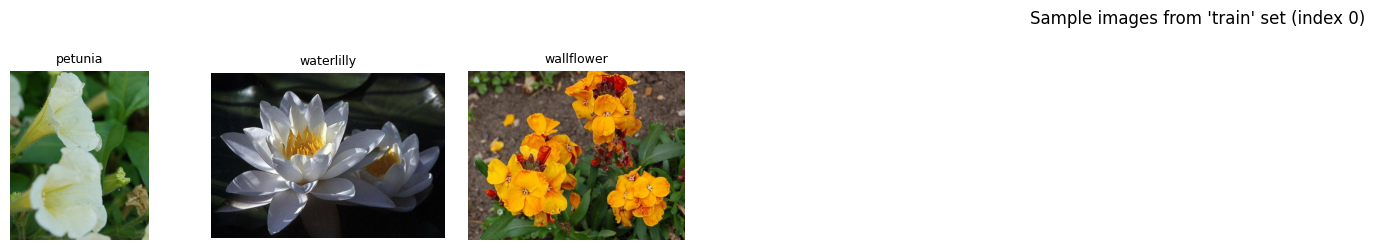

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import math

def show_sample_images_by_index(base_dir, class_names, split="train", index=0, images_per_row=10):
    """
    Displays one image per class from the specified dataset split, arranged in rows.

    Parameters:
    - base_dir: root folder with subfolders 'train', 'validation', 'test'
    - class_names: list or dict of class folder names
    - split: which split to use ('train', 'validation', 'test')
    - index: which image to show per class (0 = first image)
    - images_per_row: how many images to display per row
    """
    num_classes = len(class_names)
    rows = math.ceil(num_classes / images_per_row)

    plt.figure(figsize=(images_per_row * 2.5, rows * 2.5))

    for i, class_name in enumerate(class_names):
        class_folder = os.path.join(base_dir, split, class_name)
        image_files = sorted(os.listdir(class_folder))

        if index >= len(image_files):
            print(f"⚠️ Not enough images in class '{class_name}'")
            continue

        image_path = os.path.join(class_folder, image_files[index])
        image = Image.open(image_path)

        plt.subplot(rows, images_per_row, i + 1)
        plt.imshow(image)
        plt.title(class_name, fontsize=9)
        plt.axis('off')

    plt.suptitle(f"Sample images from '{split}' set (index {index})")
    plt.tight_layout()
    plt.show()


# Show first image from each class in the training set
show_sample_images_by_index(base_folder,  list(selected_classes.values()), split="train", index=0)

## Create Dataset Loaders (or) Load the Data

### Create Datasets from folders
- **`image_dataset_from_directory(directory)`**:
 - available in Keras with TensorFlow backend only – not compatible with PyTorch)
  1. Assumes the folder structure follows the format: class-specific subfolders within `train`, `validation`, and `test` directories.
  2. Scans and indexes image files in each subdirectory, automatically assigning labels based on folder names.
  3. Returns a `tf.data.Dataset` object that:
     - Loads and shuffles the files,
     - Decodes images into tensors,
     - Resizes images to a consistent size,
     - Batches images for efficient model training and evaluation.


https://keras.io/api/data_loading/image/

In [ ]:
batch_size = 32
image_size = (180, 180)

from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    base_folder + "train",
    image_size=image_size,
    seed=42,
    batch_size=batch_size)
validation_dataset = image_dataset_from_directory(
    base_folder  + "validation",
    image_size=image_size,
    seed=42,
    batch_size=batch_size)
test_dataset = image_dataset_from_directory(
    base_folder  + "test",
    image_size=image_size,
    shuffle = False,
    seed=42,
    batch_size=batch_size)



Found 452 files belonging to 3 classes.
Found 96 files belonging to 3 classes.
Found 100 files belonging to 3 classes.


- `tf.data.Dataset` is an iterator:

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break
for data_batch, labels_batch in validation_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)
data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## Use a pretrained model (transfer learning)
- instead of training the model from scratch, we use (a part of) a pre-trained CNN model
- pretrained models in Keras: https://keras.io/api/applications/
- popular dataset for pretraining: ImageNet: https://en.wikipedia.org/wiki/ImageNet

### Methods:
- using a pretrained model without modification (see https://github.com/reitezuz/18NES1-2025-/blob/e4c31ef4021586ff5581cfb0afbf2a1c5981eb57/week9/pretrained_model.ipynb)
- 1. Efficient feature extraction
- 2. Feature extraction with data augmentation
- 3. Fine-tuning

### 1. Efficient feature extraction:
- example model: VGG-16 model pretrained on ImageNet
- from the model, we take just the convolutional base:

#### 1. Download the convolutional base model:

In [ ]:
# download just the convolutional base of VGG16:
import keras
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 2. Extract features from the training dataset using the convolutional base:

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images, batch_size=64, verbose = False)  # Use batch prediction
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

print("train")
train_features, train_labels =  get_features_and_labels(train_dataset)
print("validation")
val_features, val_labels =  get_features_and_labels(validation_dataset)
print("test")
test_features, test_labels =  get_features_and_labels(test_dataset)

train_features.shape



train
validation
test


(452, 5, 5, 512)

#### 3. Define and train a MLP model on the extracted features:

In [ ]:
# Define the model architecture
from keras import layers
def get_model(num_classes):
    inputs = keras.Input(shape=(5, 5, 512))
    x = layers.Flatten()(inputs)
    x = layers.Dense(256)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    #model.build(input_shape=(None, 5, 5, 512))
    return model
model = get_model(num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,277,827 (12.50 MB)

 Trainable params: 3,277,827 (12.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Data frame for results
import pandas as pd

columns = ["Model Name", "Test Accuracy", "Test Loss", "Train Accuracy", "Train Loss", "Time (s)", "Epochs", "Details"]
results_df = pd.DataFrame(columns=columns)


In [ ]:
# plot the training progress:
def plot_history(history):
    history_dict = history.history
    print(history_dict.keys())

    from matplotlib import pyplot as plt

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


### Train:

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,277,827 (12.50 MB)

 Trainable params: 3,277,827 (12.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.7266 - loss: 12.4317 - val_accuracy: 0.9896 - val_loss: 0.9555
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9861 - loss: 0.2734 - val_accuracy: 0.9896 - val_loss: 0.1488
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9984 - loss: 0.1176 - val_accuracy: 0.9896 - val_loss: 0.1242
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9991 - loss: 0.0218 - val_accuracy: 0.9896 - val_loss: 0.7079
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9970 - loss: 0.0121 - val_accuracy: 0.9896 - val_loss: 0.0800
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9996 - loss: 0.0113 - val_accuracy: 0.9896 - val_loss: 0.0778
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.9896 - val_loss: 0.9060
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 

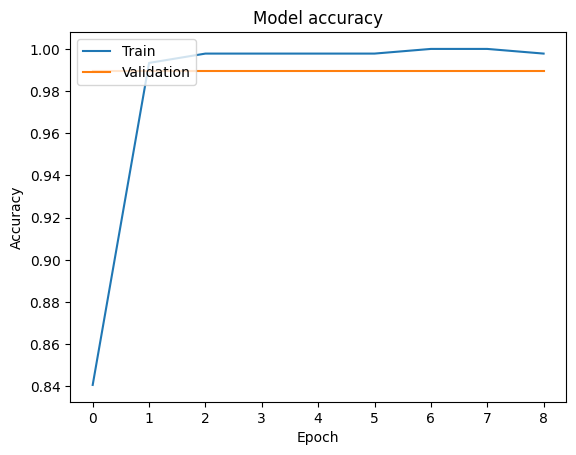

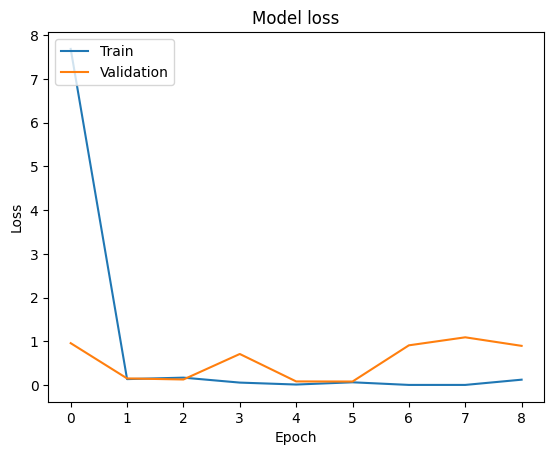

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0000e+00
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9909 - loss: 0.0681   
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9939 - loss: 0.1030    
Training accuracy: 1.0 
Train loss: 0.0
Validation accuracy: 0.9895833134651184 
Val loss: 0.07780923694372177
Test accuracy: 0.9900000095367432 
Test loss: 0.16928406059741974
Results:
                         Model Name  Test Accuracy  Test Loss  Train Accuracy  \
0  extracted_features_flowers.keras           0.99   0.169284             1.0   

   Train Loss   Time (s) Epochs             Details  
0         0.0  20.038373      9  True-ep.:30-bs:32   


C:\Users\zuzka\AppData\Local\Temp\ipykernel_15284\482476565.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)


In [ ]:
# Set some of the hyperparameters:
do_early_stopping = True
do_tensorboard = True
max_epochs = 30

details = "" # your comment

###############################################
# Define the model architecture:
import keras
from keras import layers
# Define the model architecture
model = get_model(num_classes)

import datetime
model_name = 'extracted_features_flowers.keras'
model.summary()

# Configure the model:
optimizer = keras.optimizers.Adam(learning_rate = 0.001)  # Adam, RMSProp, SGD
model.compile(optimizer=optimizer,
                  loss= keras.losses.SparseCategoricalCrossentropy(),
                  metrics= [keras.metrics.SparseCategoricalAccuracy("accuracy")])

###############################################
# Define callbacks (e.g., early stopping):
callbacks = []
if do_early_stopping:
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    callbacks.append(early_stopping)
if do_tensorboard:
    from keras.callbacks import TensorBoard
    tensorboard_callback = TensorBoard(log_dir="./logs_flowers/"+model_name, histogram_freq=1, write_steps_per_second=True)
    callbacks.append(tensorboard_callback)

################################################
# Train the model
import time
start_time = time.time()
history = model.fit(train_features, train_labels, epochs=max_epochs, batch_size=batch_size,
                    validation_data=(val_features, val_labels),
                    callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

# Evaluate the model on the training, validation and test sets
train_loss, train_acc = model.evaluate(train_features, train_labels)
val_loss, val_acc = model.evaluate(val_features, val_labels)
test_loss, test_acc = model.evaluate(test_features, test_labels)

print('Training accuracy:', train_acc, '\nTrain loss:', train_loss)
print('Validation accuracy:', val_acc, '\nVal loss:', val_loss)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
model_details = f"{do_early_stopping}-ep.:{max_epochs}-bs:{batch_size} {details}"
new_entry = {
    "Model Name" : model_name,
    "Details" : model_details,
    "Test Accuracy" : test_acc,
    "Test Loss" : test_loss,
    "Train Accuracy" : train_acc,
    "Train Loss" : train_loss,
    "Time (s)" : time_fit,
    "Epochs" : len(history.epoch),
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
# View and and save the dataframe:
results_df.to_csv(model_dir + "flowers_results.csv", index=False)
print("Results:")
print(results_df)



### Confusion matrix and some misclassified images

Misclassified: 2 out of 196 , accuracy: 0.9898


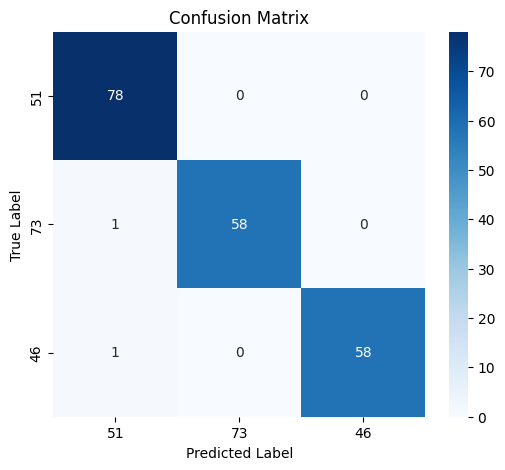

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random

# Combine validation and test data
plot_features = np.concatenate([val_features, test_features])
plot_labels = np.concatenate([val_labels, test_labels])

# Predict using your classifier
plot_preds = model.predict(plot_features, verbose=False)
y_pred = np.argmax(plot_preds, axis=1)
y_true = plot_labels

# Compute accuracy
misclassified_indices = np.where(y_pred != y_true)[0]
num_misclassified = len(misclassified_indices)
acc = (len(y_true) - num_misclassified) / len(y_true)
print("Misclassified:", num_misclassified, "out of", len(y_true), ", accuracy:", round(acc, 4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
label_to_name = list(selected_classes.keys())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_to_name, yticklabels=label_to_name)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



## Feature extraction with data augmentation

1. Download and freeze the VGG16 convolutional base:



In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

2. Freeze the convolutional base:

In [ ]:
# Print the list of trainable weights before and after freezing
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


3. Define the final model:

In [ ]:
def get_model_with_data_augmentation(num_classes):
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
            layers.RandomContrast(0.1),
            layers.RandomBrightness(0.1),
            layers.RandomTranslation(0.1, 0.1),
        ]
    )

    inputs = keras.Input(shape=image_size + (3, ))
    x = data_augmentation(inputs)
    x = keras.applications.vgg16.preprocess_input(x)
    x = conv_base(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    #model.build(input_shape=(None, 180, 180, 3))

    return model
model = get_model_with_data_augmentation(num_classes)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ input_layer_4[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │  3,277,056 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 3)         │        771 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,992,515 (68.64 MB)

 Trainable params: 3,277,827 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

4. Train the model:

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 180, 180,  │          0 │ input_layer_8[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 180, 180,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 180, 180,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 12800)     │          0 │ vgg16[2][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │  3,277,056 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 3)         │        771 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,992,515 (68.64 MB)

 Trainable params: 3,277,827 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 105s 7s/step - accuracy: 0.5875 - loss: 30.4658 - val_accuracy: 0.9896 - val_loss: 0.2008
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 128s 9s/step - accuracy: 0.9779 - loss: 0.6153 - val_accuracy: 0.9896 - val_loss: 0.1328
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 178s 12s/step - accuracy: 0.9905 - loss: 0.2946 - val_accuracy: 0.9896 - val_loss: 0.1662
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 243s 16s/step - accuracy: 0.9801 - loss: 0.8690 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 222s 15s/step - accuracy: 0.9886 - loss: 0.5148 - val_accuracy: 0.9896 - val_loss: 0.2931
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 212s 14s/step - accuracy: 0.9957 - loss: 0.0971 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 225s 15s/step - accuracy: 0.9914 - loss: 0.2494 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 212s 14s/step - accuracy: 0.9828 - loss: 1.1987 - val_a

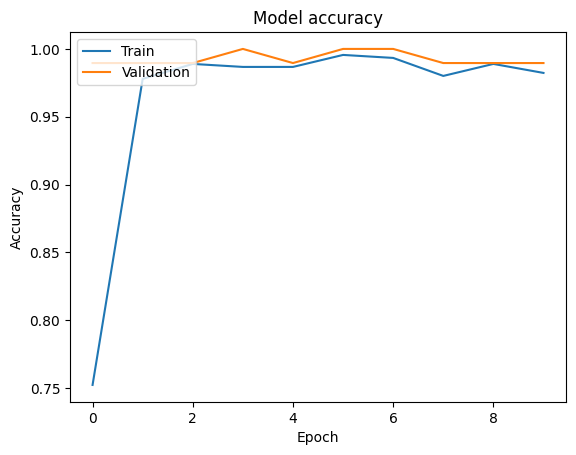

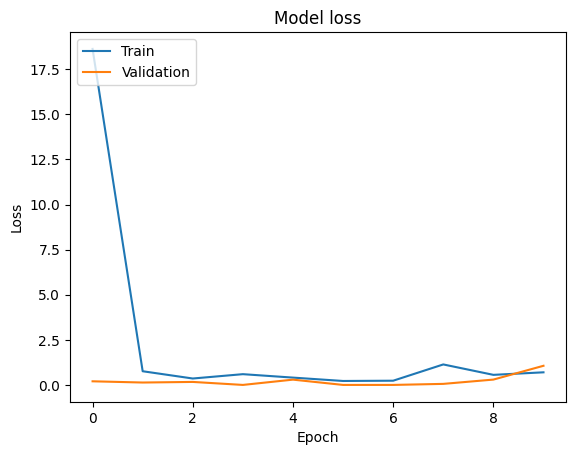

15/15 ━━━━━━━━━━━━━━━━━━━━ 171s 11s/step - accuracy: 0.9987 - loss: 0.0940
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 12s/step - accuracy: 0.9909 - loss: 0.9285 
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 9s/step - accuracy: 1.0000 - loss: 0.0000e+00
Training accuracy: 0.997787594795227 
Train loss: 0.15762707591056824
Validation accuracy: 0.9895833134651184 
Val loss: 1.0610880851745605
Test accuracy: 1.0 
Test loss: 0.0
Results:
                                 Model Name  Test Accuracy  Test Loss  \
0          extracted_features_flowers.keras           0.99   0.169284   
1  feature_extraction_augment_flowers.keras           1.00   0.000000   

   Train Accuracy  Train Loss     Time (s) Epochs              Details  
0        1.000000    0.000000    20.038373      9   True-ep.:30-bs:32   
1        0.997788    0.157627  1987.938128     10  False-ep.:10-bs:32   


In [ ]:
# Set some of the hyperparameters:
do_early_stopping = False
do_tensorboard = True
max_epochs = 10
details = "" # your comment

###############################################
# Define the model architecture:
import keras
from keras import layers
# Define the model architecture
model = get_model_with_data_augmentation(num_classes)

import datetime
model_name = "feature_extraction_augment_flowers.keras" #_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.keras'
model.summary()

# Configure the model:
optimizer = keras.optimizers.Adam(learning_rate = 0.001)  # Adam, RMSProp, SGD
model.compile(optimizer=optimizer,
                  loss= keras.losses.SparseCategoricalCrossentropy(),
                  metrics= [keras.metrics.SparseCategoricalAccuracy("accuracy")])

###############################################
# Define callbacks (e.g., early stopping):
callbacks = []
if do_early_stopping:
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    callbacks.append(early_stopping)
if do_tensorboard:
    from keras.callbacks import TensorBoard
    tensorboard_callback = TensorBoard(log_dir="./logs_flowers/"+model_name, histogram_freq=1, write_steps_per_second=True)
    callbacks.append(tensorboard_callback)

################################################
# Train the model
import time
start_time = time.time()
history = model.fit(train_dataset, epochs=max_epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

# Evaluate the model on the training, validation and test sets
train_loss, train_acc = model.evaluate(train_dataset)
val_loss, val_acc = model.evaluate(validation_dataset)
test_loss, test_acc = model.evaluate(test_dataset)

print('Training accuracy:', train_acc, '\nTrain loss:', train_loss)
print('Validation accuracy:', val_acc, '\nVal loss:', val_loss)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
model_details = f"{do_early_stopping}-ep.:{max_epochs}-bs:{batch_size} {details}"
new_entry = {
    "Model Name" : model_name,
    "Details" : model_details,
    "Test Accuracy" : test_acc,
    "Test Loss" : test_loss,
    "Train Accuracy" : train_acc,
    "Train Loss" : train_loss,
    "Time (s)" : time_fit,
    "Epochs" : len(history.epoch),
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
# View and and save the dataframe:
results_df.to_csv(model_dir + "mnist_results.csv", index=False)
print("Results:")
print(results_df)

In [ ]:
for images, labels in train_dataset.take(1):
    print("Label shape:", labels.shape)
    print("Labels:", labels.numpy())
print("image_size =", image_size)

Label shape: (32,)
Labels: [2 0 0 0 2 0 1 0 1 1 1 0 0 0 2 0 2 1 1 0 1 0 2 2 2 2 2 0 0 0 1 0]
image_size = (180, 180)


5.  Confusion matrix and some misclassified images

Number of misclassified images: 1 out of 196 , accuracy: 0.9949


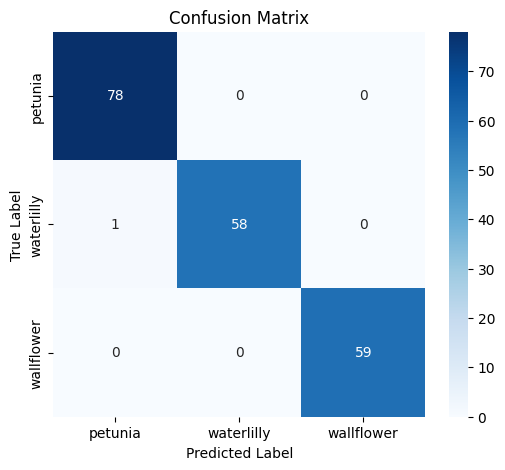

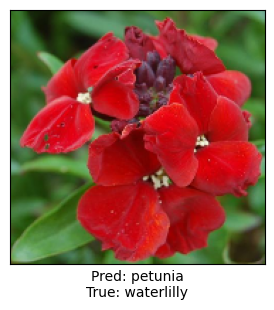

In [ ]:
def do_plot_confusion_matrix(model, dataset, num_classes):
    import random
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    label_to_name = list(selected_classes.values())
    label_mapping = {i: name for i, name in enumerate(label_to_name)}

    y_true = []
    y_pred = []
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    # Predict and collect results
    for images, labels in plot_dataset:
        preds = model.predict(images, verbose=False)
        preds = np.argmax(preds, axis=1)
        labels_np = labels.numpy()
        images_np = images.numpy()

        y_true.extend(labels_np)
        y_pred.extend(preds)

        for i in range(len(images)):
            if preds[i] != labels_np[i]:
                misclassified_images.append(images_np[i])
                misclassified_labels.append(labels_np[i])
                misclassified_predictions.append(int(preds[i]))

    # Convert to arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    misclassified_images = np.array(misclassified_images)
    misclassified_labels = np.array(misclassified_labels)
    misclassified_predictions = np.array(misclassified_predictions)

    # Accuracy
    misclassified_indices = np.where(y_pred != y_true)[0]
    num_misclassified = len(misclassified_indices)
    test_acc = (len(y_true) - num_misclassified) / len(y_true)
    print("Number of misclassified images:", num_misclassified,
          "out of", len(y_true), ", accuracy:", round(test_acc, 4))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    figsize=(6, 5)
    if num_classes >= 10:
        figsize = (60, 50)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_to_name, yticklabels=label_to_name)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Show misclassified images with names
    num_images_to_plot = 20
    random_indices = random.sample(range(len(misclassified_images)), min(num_images_to_plot, len(misclassified_images)))

    plt.figure(figsize=(15, 12))
    for i, index in enumerate(random_indices):
        true_label = label_mapping[misclassified_labels[index]]
        pred_label = label_mapping[misclassified_predictions[index]]

        plt.subplot(4, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(misclassified_images[index].astype("uint8"))
        plt.xlabel(f"Pred: {pred_label}\nTrue: {true_label}")
    plt.tight_layout()
    plt.show()

plot_dataset = validation_dataset.concatenate(test_dataset)
do_plot_confusion_matrix(model, plot_dataset, num_classes)


## Fine tuning

- Use the previous model and freeze all layers until the fourth from the last:



In [ ]:

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

conv_base.trainable = False
print("This is the number of trainable weights in the conv base:", len(conv_base.trainable_weights))


This is the number of trainable weightsin the conv base: 0


2. Define the final model:

3. Train the model

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 180, 180,  │          0 │ input_layer_8[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 180, 180,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 180, 180,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 12800)     │          0 │ vgg16[2][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │  3,277,056 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 3)         │        771 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,548,171 (93.64 MB)

 Trainable params: 3,277,827 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 6,555,656 (25.01 MB)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 274s 18s/step - accuracy: 0.9896 - loss: 0.7253 - val_accuracy: 0.9896 - val_loss: 1.0563
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 226s 15s/step - accuracy: 0.9872 - loss: 0.4937 - val_accuracy: 0.9896 - val_loss: 1.0500
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 243s 16s/step - accuracy: 0.9903 - loss: 0.3792 - val_accuracy: 0.9896 - val_loss: 1.0472
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 229s 15s/step - accuracy: 0.9874 - loss: 0.5707 - val_accuracy: 0.9896 - val_loss: 1.0428
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 217s 15s/step - accuracy: 0.9876 - loss: 0.4332 - val_accuracy: 0.9896 - val_loss: 1.0358
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


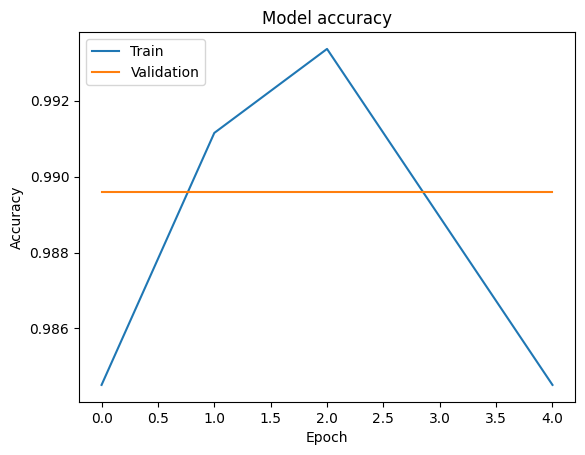

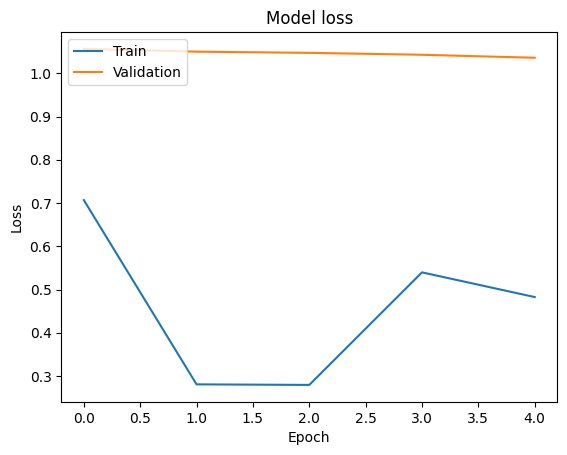

15/15 ━━━━━━━━━━━━━━━━━━━━ 163s 11s/step - accuracy: 0.9963 - loss: 0.2477
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 12s/step - accuracy: 0.9909 - loss: 0.9064 
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step - accuracy: 1.0000 - loss: 0.0000e+00
Training accuracy: 0.997787594795227 
Train loss: 0.14821089804172516
Validation accuracy: 0.9895833134651184 
Val loss: 1.0358474254608154
Test accuracy: 1.0 
Test loss: 0.0
Results:
                                 Model Name  Test Accuracy  Test Loss  \
0          extracted_features_flowers.keras           0.99   0.169284   
1  feature_extraction_augment_flowers.keras           1.00   0.000000   
2        feature_extraction_finetuned.keras           1.00   0.000000   

   Train Accuracy  Train Loss     Time (s) Epochs              Details  
0        1.000000    0.000000    20.038373      9   True-ep.:30-bs:32   
1        0.997788    0.157627  1987.938128     10  False-ep.:10-bs:32   
2        0.997788    0.148211  1189.507604      5   False-ep.:5-bs:32   


In [ ]:
# Set some of the hyperparameters:
do_early_stopping = False
do_tensorboard = True
max_epochs = 5
learning_rate = 0.000001
details = "" # your comment

###############################################
# Define the model architecture:
import keras
from keras import layers
# Define the model architecture ...already defined
#model = get_model_with_data_augmentation()

import datetime
model_name = "feature_extraction_finetuned.keras" #_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.keras'
model.summary()

# Configure the model:
optimizer = keras.optimizers.Adam(learning_rate = learning_rate)  # Adam, RMSProp, SGD
model.compile(optimizer=optimizer,
                  loss= keras.losses.SparseCategoricalCrossentropy(),
                  metrics= [keras.metrics.SparseCategoricalAccuracy("accuracy")])

###############################################
# Define callbacks (e.g., early stopping):
callbacks = []
if do_early_stopping:
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    callbacks.append(early_stopping)
if do_tensorboard:
    from keras.callbacks import TensorBoard
    tensorboard_callback = TensorBoard(log_dir="./logs_flowers/"+model_name, histogram_freq=1, write_steps_per_second=True)
    callbacks.append(tensorboard_callback)

################################################
# Train the model
import time
start_time = time.time()
history = model.fit(train_dataset, epochs=max_epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

# Evaluate the model on the training, validation and test sets
train_loss, train_acc = model.evaluate(train_dataset)
val_loss, val_acc = model.evaluate(validation_dataset)
test_loss, test_acc = model.evaluate(test_dataset)

print('Training accuracy:', train_acc, '\nTrain loss:', train_loss)
print('Validation accuracy:', val_acc, '\nVal loss:', val_loss)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
model_details = f"{do_early_stopping}-ep.:{max_epochs}-bs:{batch_size} {details}"
new_entry = {
    "Model Name" : model_name,
    "Details" : model_details,
    "Test Accuracy" : test_acc,
    "Test Loss" : test_loss,
    "Train Accuracy" : train_acc,
    "Train Loss" : train_loss,
    "Time (s)" : time_fit,
    "Epochs" : len(history.epoch),
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
# View and and save the dataframe:
results_df.to_csv(model_dir + "mnist_results.csv", index=False)
print("Results:")
print(results_df)

# Exercise
- compare the results with the results of the model trained from scratch



In [ ]:
###############################################
# Load TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard before training begins
%tensorboard --logdir logs_flowers --reload_interval=1